## An Analysis of socio-economic factors on national graduation rate

This project uses the EDFacts data consisting of district level statistics on graduation rates and performance on math & reading/language art assessments by race/ethnicity, gender, disability, English proficiency and socioeconomic status for two years 2011 and 2014. The objective of the project is

1) Determine if correlations between these variables (race, poverty, disabilities etc.) and cohort graduation rates exist. Does any state has less cohort graduation rate compare to another state? What variables most influence the cohort graduation rate per state?

2) Determine if there is a statistically significant difference between Northeast, Midwest, South and West region in cohort graduation rate per district. Perform k-means clustering to discover if cohort data can accurately predict a region.

3) Create regression model using machine learning to predict cohort graduation rate per district given EDFacts data for a particular district. This model could be used to granularize the district into schools and provide more localized estimates of cohort graduation rate.

In [325]:
%pylab inline

import re
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
sns.set_style(style='white')

import statsmodels as sm
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ztest
import geopandas as gpd
import pysal

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/Users/subhabratamukherjee/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['e', 'clf', 'f', 'norm', 'test', 'mean', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [326]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [327]:
#Get State Code From State Code
def getStateCode(statecode):
    data = pd.read_csv('data/state.txt')
    dfstate = data.loc[data['CODE'] == statecode]
    
    return dfstate.ST.values

In [328]:
#Get FIPS Code From State Name
def getStateName(statecode):
    data = pd.read_csv('data/state.txt')
    dfstate = data.loc[data['CODE'] == statecode]
    
    return dfstate.STATENAME.values

## Data Exploration

To begin, we'll examine relationships in the cohort graduation data set. Later in the analysis, we will pull in EDFacts data to understand each district's racial distribution, ELSI data, poverty data and assessment data, etc.
First, we'll look at two statements made by Department of Education when introducing this dataset:

1) In school year 2014–15, the adjusted cohort graduation rate (ACGR) for public high school students rose to 83 percent, the highest rate since the measure was first collected in 2010–11.

2) Asian/Pacific Islander students had the highest ACGR (90 percent), followed by White (88 percent), Hispanic (78 percent), Black (75 percent), and American Indian/Alaska Native (72 percent) students

* https://nces.ed.gov/programs/coe/indicator_coi.asp

### Average adjusted cohort graduation rate (ACGR)

In [329]:
print(color.BOLD + 'First, let\'s test the statement made by Department of Education that "The adjusted cohort \ngraduation rate (ACGR) for public high school students rose to 83%.' + color.BOLD)

acgr2011 = pd.read_csv("data/high-school-dropout-dataset2011.csv", dtype={"LEAID": str})
acgr2014 = pd.read_csv("data/high-school-dropout-dataset2014.csv", dtype={"LEAID": str})

nationalacgr2011 = int(round(np.sum(acgr2011['ALLG'])*100/np.sum(acgr2011['ALLA']),0))
nationalacgr2014 = int(round(np.sum(acgr2014['ALLG'])*100/np.sum(acgr2014['ALLA']),0))

print(color.BOLD + '\nAfter verifying the clean regulatory adjusted cohort graduation rate for all district we \ncan see that in school year 2014-15 the graduation rate at the national level is %s%%, an \nincrease from %s%% in 2011-12. How does the graduation rate vary depending on the state? \nThis will be explored later in the analysis.' 
      %(nationalacgr2011, nationalacgr2014) + color.BOLD)

First, let's test the statement made by Department of Education that "The adjusted cohort 
graduation rate (ACGR) for public high school students rose to 83%.

After verifying the clean regulatory adjusted cohort graduation rate for all district we 
can see that in school year 2014-15 the graduation rate at the national level is 80%, an 
increase from 83% in 2011-12. How does the graduation rate vary depending on the state? 
This will be explored later in the analysis.



Now check how the graduation rates are distributed at the district level for school year 
2011-12 and 2014-15.


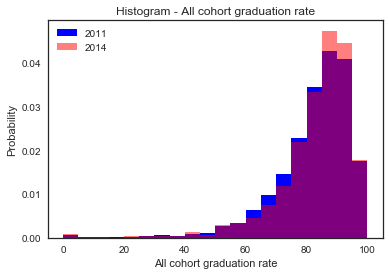


From the above histogram we can assume that the adjusted cohort graduation rate is skewed 
Normal distribution. Hence we can apply the pricipal of statistical hypothesis to conclude that graduation rate at the national level is 83%.

Hence we construct our Hypothesis as follows

NULL HYPOTHESIS: 

The national adjusted cohort graduation rate is 83%

ALTERNATE HYPOTHESIS: 

The national adjusted cohort graduation rate is not 83%


In [330]:
print(color.BOLD + '\nNow check how the graduation rates are distributed at the district level for school year \n2011-12 and 2014-15.' + color.BOLD)

acgr2011r = acgr2011[['ALLP', 'MASP', 'MWHP', 'MBLP', 'MHIP', 'MHIP','CWDP', 'ECDP', 
                      'LEPP', 'CHSR', 'PUSR', 'FRLR', 'SETR', 'SECR', 'CHIR', 'POVR']]

acgr2014r = acgr2014[['ALLP', 'MASP', 'MWHP', 'MBLP', 'MHIP', 'MHIP','CWDP', 'ECDP', 
                      'LEPP', 'CHSR', 'PUSR', 'FRLR', 'SETR', 'SECR', 'CHIR', 'POVR']]

plt.hist(acgr2011r['ALLP'], bins=20, histtype='bar', normed=True, color='b', label='2011')
plt.hist(acgr2014r['ALLP'], bins=20, histtype='bar', normed=True, color='r', alpha=0.5, label='2014')
plt.title("Histogram - All cohort graduation rate")
plt.xlabel("All cohort graduation rate")
plt.ylabel("Probability")
plt.legend()
plt.show()

print(color.BOLD + '\nFrom the above histogram we can assume that the adjusted cohort graduation rate is skewed \nNormal distribution.', 
      'Hence we can apply the pricipal of statistical hypothesis to conclude that graduation rate at the national level is %s%%.' %(nationalacgr2014) + color.BOLD)

print(color.BOLD + '\nHence we construct our Hypothesis as follows' + color.BOLD)
print(color.BOLD + '\nNULL HYPOTHESIS:', color.BOLD)
print(color.BOLD + '\nThe national adjusted cohort graduation rate is 83%' + color.BOLD)
print(color.BOLD + '\nALTERNATE HYPOTHESIS:', color.BOLD)
print(color.BOLD + '\nThe national adjusted cohort graduation rate is not 83%' + color.BOLD)

In [331]:
acgr2014r = acgr2014[acgr2014['ALLP'] !=0]
dftest = acgr2014r.take(np.random.permutation(len(acgr2014r))[:200])

mean = round(dftest.ALLP.mean(),2)
sd = round(dftest.ALLP.std(),2)

zstat, pval = ztest(acgr2014r['ALLP'], x2=None, value=83, alternative='two-sided', usevar='pooled', ddof=1.0)

print(color.BOLD + '\nWe are having a random sample of 200 records with mean %s and standard deviation %s, \nn = 200 is large enough for the CLT to apply so the distribution of sample means is \napproximately normal.'%(mean, sd),
                    'The population SD is unknown, so a z-test is called with H0 = 83.0 \nand Ha <> 83.0' + color.BOLD)


print(color.BOLD + "\nThe test result shows the test z-statistic as %s and the and P-value as %s" %(round(zstat, 4), round(pval,4)), 
                    "With \nthis P-value, %s > 0.05, there is sufficient evidence that we cannot reject H0 and \nthere is sufficient evidence that that the national adjusted cohort graduation rate is %s%%."%(round(pval,4), nationalacgr2014) + color.BOLD)


We are having a random sample of 200 records with mean 83.69 and standard deviation 10.8, 
n = 200 is large enough for the CLT to apply so the distribution of sample means is 
approximately normal. The population SD is unknown, so a z-test is called with H0 = 83.0 
and Ha <> 83.0

The test result shows the test z-statistic as -1.6058 and the and P-value as 0.1083 With 
this P-value, 0.1083 > 0.05, there is sufficient evidence that we cannot reject H0 and 
there is sufficient evidence that that the national adjusted cohort graduation rate is 83%.


In [332]:
acgrMAM2014 = int(round(np.sum(acgr2014['MAMG'])*100/np.sum(acgr2014['MAMA']),0))
acgrMAS2014 = int(round(np.sum(acgr2014['MASG'])*100/np.sum(acgr2014['MASA']),0))
acgrMBL2014 = int(round(np.sum(acgr2014['MBLG'])*100/np.sum(acgr2014['MBLA']),0))
acgrMHI2014 = int(round(np.sum(acgr2014['MHIG'])*100/np.sum(acgr2014['MHIA']),0))
acgrMWH2014 = int(round(np.sum(acgr2011['MWHG'])*100/np.sum(acgr2011['MWHA']),0))

print(color.BOLD + 'Now, let\'s verify the other statement made by Department of Education that "In school year 2014-15, Asian/Pacific Islander students had the highest ACGR of 90%, followed by White 88%\n, Hispanic 78%, Black 75% and American Indian/Alaska Native 72% students.' + color.BOLD)

print(color.BOLD + '\nAfter calculating the cohort graduation rate for major racial and ethnic groups, we can see that in school year 2014–15 Asian/Pacific Islander students has the highest ACGR of %s%%, \nfollowed by white %s%%, Hispanic %s%%, Black %s%% and American Indian/Alaska Native %s%%.' 
      %(acgrMAS2014, acgrMWH2014, acgrMHI2014, acgrMBL2014, acgrMAM2014), 'The \ndata is closely matching with statistics from Department of Education.', color.BOLD)

print(color.BOLD + '\nNow check the states which are doing better than other state. In order to have a better \nvisual representation we have plotted the chloropleth map with the data from school year \n2014-15 after removing Hawaii and Alaska.' + color.BOLD)

Now, let's verify the other statement made by Department of Education that "In school year 2014-15, Asian/Pacific Islander students had the highest ACGR of 90%, followed by White 88%
, Hispanic 78%, Black 75% and American Indian/Alaska Native 72% students.

After calculating the cohort graduation rate for major racial and ethnic groups, we can see that in school year 2014–15 Asian/Pacific Islander students has the highest ACGR of 89%, 
followed by white 87%, Hispanic 80%, Black 77% and American Indian/Alaska Native 67%. The 
data is closely matching with statistics from Department of Education. 

Now check the states which are doing better than other state. In order to have a better 
visual representation we have plotted the chloropleth map with the data from school year 
2014-15 after removing Hawaii and Alaska.


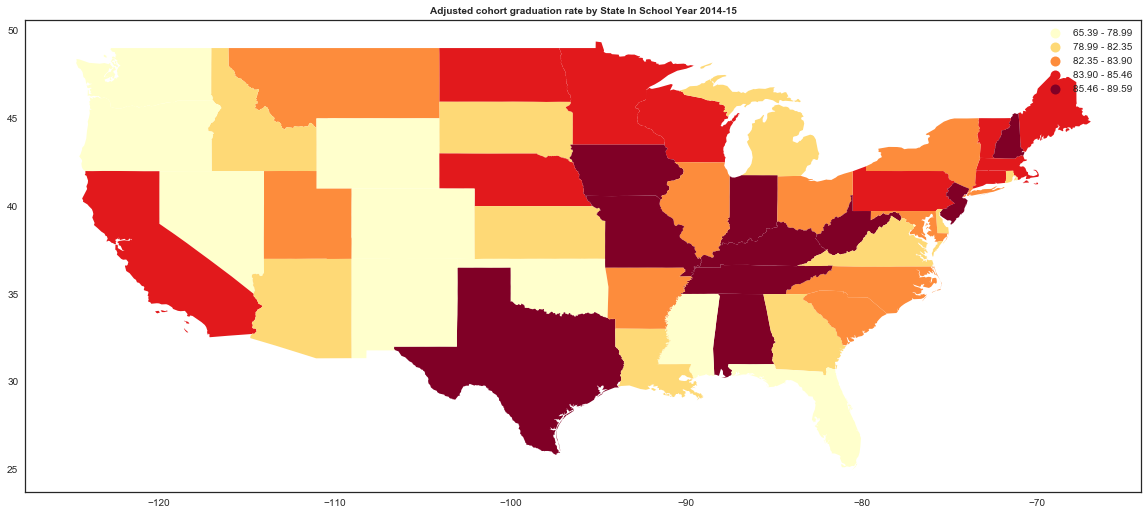


From the above heatmap it is very clear that the school district in Northeast and South region is doing better than the school district in Widwest and west region. Now check how 
these states are doing over time. 


In [333]:
acgrBySt2011 = round(acgr2011.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2011 = acgrBySt2011.sort_values('ALLA', ascending=False)
acgrBySt2011['ALLP'] = round(acgrBySt2011['ALLG']*100/acgrBySt2011['ALLA'],2)

acgrBySt2014 = round(acgr2014.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2014 = acgrBySt2014.sort_values('ALLA', ascending=False)
acgrBySt2014['ALLP'] = round(acgrBySt2014['ALLG']*100/acgrBySt2014['ALLA'],2)

sf = gpd.GeoDataFrame.from_file("data/states_21basic/states.shp")

sf['STATE_FIPS'] = pd.to_numeric(sf['STATE_FIPS'])
sf.rename(index=str, columns={"STATE_FIPS": "FIPCD"}, inplace=True)

response_map = pd.merge(sf,acgrBySt2014,on='FIPCD')
response_map = response_map[response_map['STATE_NAME'] != 'Hawaii']
response_map = response_map[response_map['STATE_NAME'] != 'Alaska']

ax = response_map.plot(column='ALLP', scheme='quantiles', k=5, cmap='YlOrRd', legend=True, figsize=(20,10));
ax.set_title('Adjusted cohort graduation rate by State In School Year 2014-15', fontsize = 10, fontweight = 'bold');
plt.show()

print(color.BOLD + '\nFrom the above heatmap it is very clear that the school district in Northeast and South region is doing better than the school district in Widwest and west region. Now check how \nthese states are doing over time.', color.BOLD)

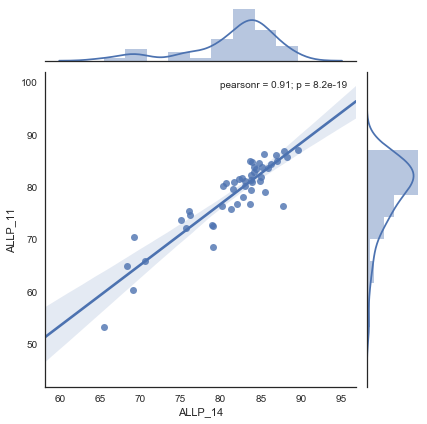


The above scatter plot, X-axis is showing the % of students graduated for each state in 
2014 and the Y-axis is showing the % of students graduated for each state in 2011. 
From this diagram this is clear that most of states are doing consistenyly well except few states.


In [334]:
acgrBySt2011 = round(acgr2011.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2011 = acgrBySt2011.sort_values('ALLA', ascending=False)
acgrBySt2011['ALLP'] = round(acgrBySt2011['ALLG']*100/acgrBySt2011['ALLA'],2)

acgrBySt2014 = round(acgr2014.groupby(['FIPCD'], as_index=False)['ALLA', 'ALLG'].sum(),2)
acgrBySt2014 = acgrBySt2014.sort_values('ALLA', ascending=False)
acgrBySt2014['ALLP'] = round(acgrBySt2014['ALLG']*100/acgrBySt2014['ALLA'],2)

dfcomb1 = pd.merge(acgrBySt2011, acgrBySt2014, how='inner', on= ['FIPCD'], left_index=False, right_index=False, sort=True, 
         suffixes=('_11', '_14'))
dfcomb2 = dfcomb1[['ALLP_11','ALLP_14']]

sns.jointplot(x="ALLP_14", y="ALLP_11", data=dfcomb2, kind="reg");

plt.show()

print(color.BOLD + '\nThe above scatter plot, X-axis is showing the % of students graduated for each state in \n2014 and the Y-axis is showing the % of students graduated for each state in 2011.', color.BOLD)
print(color.BOLD + 'From this diagram this is clear that most of states are doing consistenyly well except few states.' + color.BOLD)


Let us draw a comparison between all states and find out which states doing shaowing 
positive growth in % of students graduated.


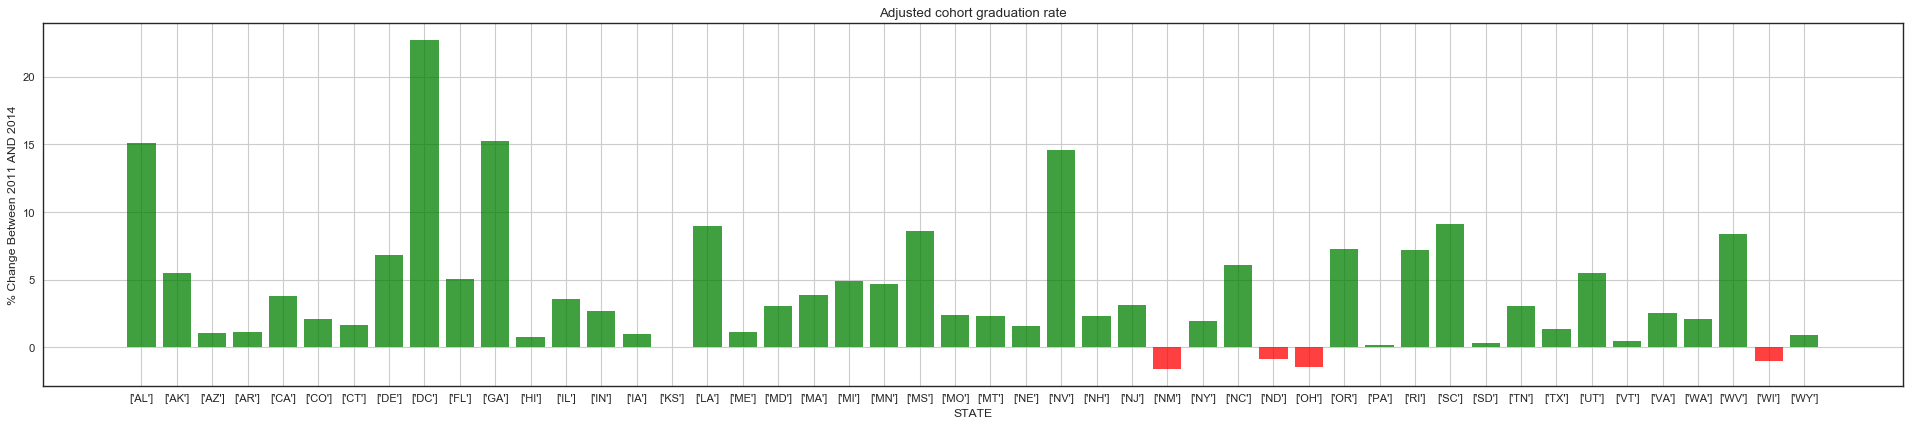

From the above histogram it is clear that most states shown positive growth in cohort 
graduation rate. 
But NEW MEXICO,NORTH DAKOTA,OHIO,WISCONSIN are the states showing negative growth in cohort graduation rate. 


In [335]:
print(color.BOLD + '\nLet us draw a comparison between all states and find out which states doing shaowing \npositive growth in % of students graduated.' + color.BOLD)

temp11 = acgrBySt2011[['FIPCD', 'ALLP']]
temp11 = temp11.groupby(['FIPCD'], as_index=False).mean()

temp14 = acgrBySt2014[['FIPCD', 'ALLP']]
temp14 = temp14.groupby(['FIPCD'], as_index=False).mean()

dfcomb = pd.merge(temp11, temp14, how='inner', on= ['FIPCD'], left_index=False, right_index=False, sort=True, 
         suffixes=('_11', '_14'))

dfcomb['Change'] = ((dfcomb['ALLP_14'] - dfcomb['ALLP_11']) / dfcomb['ALLP_11']) * 100
dfcomb['Index'] = dfcomb['FIPCD'].map(getStateCode)
dfcomb['positive'] = dfcomb['Change'] > 0
dfcomb['FIPCD'].map(getStateCode)
    
plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')

objects = dfcomb['Index']
y_pos = np.arange(len(objects))
performance = dfcomb['Change']
 
plt.bar(y_pos, performance, align='center', alpha=0.75, color=dfcomb.positive.map({True: 'g', False: 'r'}))
plt.xticks(y_pos, objects)
plt.xlabel('STATE')
plt.ylabel('% Change Between 2011 AND 2014')
plt.title('Adjusted cohort graduation rate')
plt.grid()

plt.show()

print(color.BOLD + 'From the above histogram it is clear that most states shown positive growth in cohort \ngraduation rate.', color.BOLD)

dfStWithNegGr = dfcomb[dfcomb['positive'] != True]['FIPCD'].map(getStateName)
dfStWithNegGr = dfStWithNegGr.to_string(index = False)
dfStWithNegGr = re.sub( '\n', ',', dfStWithNegGr ).strip()
dfStWithNegGr = re.sub( ',\s+', ',', dfStWithNegGr ).strip()
dfStWithNegGr = dfStWithNegGr.replace('[', '').replace(']', '')

print(color.BOLD + 'But %s are the states showing negative growth in cohort graduation rate.' 
      %(dfStWithNegGr), color.BOLD)

Now we will verify the relation between the graduation rate and the %% of major racial and ethnic groups in these states and try to find any pattern. 


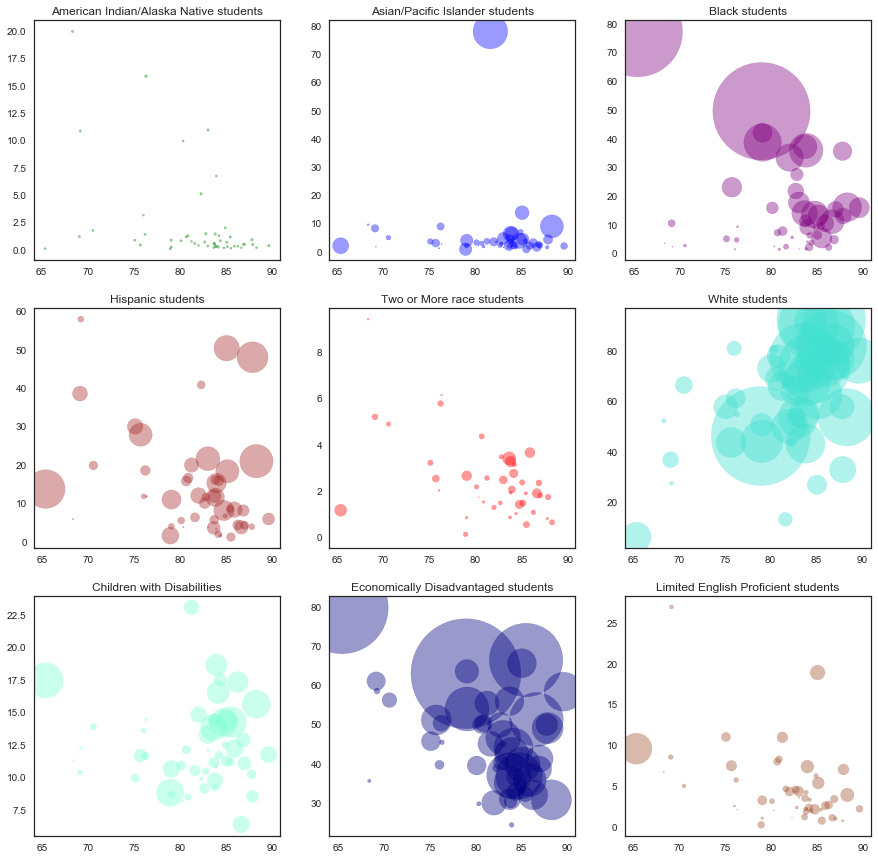

The above scatter plot is showing the % of students graduated in X-axis, % of students 
belong to a race in the Y-axis and the size of each bubble is representing the % of students graduated from the same race. 

From this diagram it is clear that % of American Indian/Alaska Native students and students with two or more has very less impact on the overall graduation rate. 


In [336]:
print(color.BOLD + 'Now we will verify the relation between the graduation rate and the %% of major racial and ethnic groups in these states and try to find any pattern.' , color.BOLD)

acgrBySt = round(acgr2014.groupby(['FIPCD'], as_index=False)[
    'ALLA', 'ALLG', 'MAMG', 'MAMA', 'MASG', 'MASA', 'MBLG', 'MBLA', 'MHIG', 'MHIA',
    'MWHG', 'MWHA', 'MTRG', 'MTRA', 'CWDG', 'CWDA', 'ECDG', 'ECDA', 'LEPG', 'LEPA'
    ].sum(),2)

acgrBySt = acgrBySt.sort_values('ALLA', ascending=False)
acgrBySt['ALLP'] = round(acgrBySt['ALLG']*100/acgrBySt['ALLA'],2)

acgrBySt['MAMP'] = round(acgrBySt['MAMG']*100/acgrBySt['MAMA'],2)
acgrBySt['MAMR'] = round(acgrBySt['MAMA']*100/acgrBySt['ALLA'],2)

acgrBySt['MASP'] = round(acgrBySt['MASG']*100/acgrBySt['MAMA'],2)
acgrBySt['MASR'] = round(acgrBySt['MASA']*100/acgrBySt['ALLA'],2)

acgrBySt['MBLP'] = round(acgrBySt['MBLG']*100/acgrBySt['MAMA'],2)
acgrBySt['MBLR'] = round(acgrBySt['MBLA']*100/acgrBySt['ALLA'],2)

acgrBySt['MHIP'] = round(acgrBySt['MHIG']*100/acgrBySt['MAMA'],2)
acgrBySt['MHIR'] = round(acgrBySt['MHIA']*100/acgrBySt['ALLA'],2)

acgrBySt['MWHP'] = round(acgrBySt['MWHG']*100/acgrBySt['MAMA'],2)
acgrBySt['MWHR'] = round(acgrBySt['MWHA']*100/acgrBySt['ALLA'],2)

acgrBySt['MTRP'] = round(acgrBySt['MTRG']*100/acgrBySt['MAMA'],2)
acgrBySt['MTRR'] = round(acgrBySt['MTRA']*100/acgrBySt['ALLA'],2)

acgrBySt['CWDP'] = round(acgrBySt['CWDG']*100/acgrBySt['MAMA'],2)
acgrBySt['CWDR'] = round(acgrBySt['CWDA']*100/acgrBySt['ALLA'],2)

acgrBySt['ECDP'] = round(acgrBySt['ECDG']*100/acgrBySt['MAMA'],2)
acgrBySt['ECDR'] = round(acgrBySt['ECDA']*100/acgrBySt['ALLA'],2)

acgrBySt['LEPP'] = round(acgrBySt['LEPG']*100/acgrBySt['MAMA'],2)
acgrBySt['LEPR'] = round(acgrBySt['LEPA']*100/acgrBySt['ALLA'],2)

acgrBySt = acgrBySt.fillna(0)

a = acgrBySt['ALLP']
b = acgrBySt['MAMR']
c = acgrBySt['MASR']
d = acgrBySt['MBLR']
e = acgrBySt['MHIR']
f = acgrBySt['MTRR']
g = acgrBySt['MWHR']
h = acgrBySt['CWDR']
i = acgrBySt['ECDR']
j = acgrBySt['LEPR']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

area = acgrBySt['MAMP']/10
axes[0, 0].scatter(a, b, s=area, color='green', alpha=0.4)
axes[0, 0].set_title("American Indian/Alaska Native students")

area = acgrBySt['MASP']/10
axes[0, 1].scatter(a, c, s=area, color='blue', alpha=0.4)
axes[0, 1].set_title("Asian/Pacific Islander students")

area = acgrBySt['MBLP']/10
axes[0, 2].scatter(a, d, s=area, color='purple', alpha=0.4)
axes[0, 2].set_title("Black students");

area = acgrBySt['MHIP']/10
axes[1, 0].scatter(a, e, s=area, color='brown', alpha=0.4)
axes[1, 0].set_title("Hispanic students");

area = acgrBySt['MTRP']/10
axes[1, 1].scatter(a, f, s=area, color='red', alpha=0.4)
axes[1, 1].set_title("Two or More race students");

area = acgrBySt['MWHP']/10
axes[1, 2].scatter(a, g, s=area, color='Turquoise', alpha=0.4)
axes[1, 2].set_title("White students");

area = acgrBySt['CWDP']/10
axes[2, 0].scatter(a, h, s=area, color='Aquamarine', alpha=0.4)
axes[2, 0].set_title("Children with Disabilities");

area = acgrBySt['ECDP']/10
axes[2, 1].scatter(a, i, s=area, color='Navy', alpha=0.4)
axes[2, 1].set_title("Economically Disadvantaged students");

area = acgrBySt['LEPP']/10
axes[2, 2].scatter(a, j, s=area, color='Sienna', alpha=0.4)
axes[2, 2].set_title("Limited English Proficient students");

plt.show()

print(color.BOLD + 'The above scatter plot is showing the % of students graduated in X-axis, % of students \nbelong to a race in the Y-axis and the size of each bubble is representing the % of students graduated from the same race.' , color.BOLD)

print(color.BOLD + '\nFrom this diagram it is clear that % of American Indian/Alaska Native students and students with two or more has very less impact on the overall graduation rate.', color.BOLD)


Hence we are going to draw the heatmap of all these variables which may have an impact on overall graduation rate. 


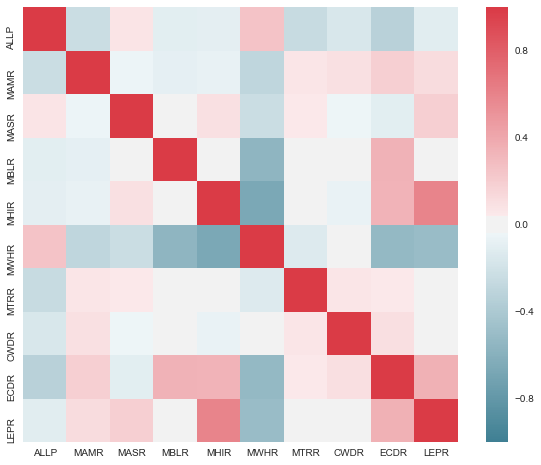


How the major racial and ethnic groups are co-related in 2014 are represented as follows

       ALLP  MAMR  MASR  MBLR  MHIR  MWHR  MTRR  CWDR  ECDR  LEPR
ALLP  1.00 -0.24  0.08 -0.11 -0.10  0.25 -0.25 -0.16 -0.34 -0.11
MAMR -0.24  1.00 -0.05 -0.09 -0.07 -0.30  0.07  0.10  0.19  0.12
MASR  0.08 -0.05  1.00  0.02  0.10 -0.23  0.05 -0.04 -0.11  0.19
MBLR -0.11 -0.09  0.02  1.00 -0.04 -0.56 -0.01 -0.01  0.35 -0.01
MHIR -0.10 -0.07  0.10 -0.04  1.00 -0.67 -0.03 -0.07  0.34  0.60
MWHR  0.25 -0.30 -0.23 -0.56 -0.67  1.00 -0.13  0.01 -0.53 -0.50
MTRR -0.25  0.07  0.05 -0.01 -0.03 -0.13  1.00  0.06  0.05 -0.02
CWDR -0.16  0.10 -0.04 -0.01 -0.07  0.01  0.06  1.00  0.11 -0.02
ECDR -0.34  0.19 -0.11  0.35  0.34 -0.53  0.05  0.11  1.00  0.36
LEPR -0.11  0.12  0.19 -0.01  0.60 -0.50 -0.02 -0.02  0.36  1.00. 

Now we are going to apply some machine learning technique to our dataset and see if we can predict a model. 


In [337]:
print(color.BOLD + '\nHence we are going to draw the heatmap of all these variables which may have an impact on overall graduation rate.', color.BOLD)

acgr = acgr2014[['ALLP','MAMR','MASR','MBLR','MHIR','MWHR','MTRR','CWDR','ECDR','LEPR']]

fig, ax = plt.subplots(figsize=(10, 8))
corr = acgr.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

plt.show()

print(color.BOLD + '\nHow the major racial and ethnic groups are co-related in 2014 are represented as follows\n\n %s.' %(corr.round(2)), color.BOLD)
print(color.BOLD + '\nNow we are going to apply some machine learning technique to our dataset and see if we can predict a model.', color.BOLD)

### Machine Learning using Linear Regression

Estimated intercept coefficient: 28.890399266
Number of coefficients: 15
   features  estimatedCoefficients
0      MASP              -0.008174
1      MASR              -0.001340
2      MBLP               0.000240
3      MBLR               0.153899
4      MHIP               0.017434
5      MHIR               0.078556
6      MWHP               0.442235
7      MWHR               0.083423
8      CWDP               0.038399
9      CWDR              -0.124293
10     ECDP               0.136187
11     ECDR              -0.053158
12     LEPP              -0.015937
13     LEPR               0.118824
14     FRLR              -0.037507
[ 83.91265629  84.56727225  91.36555237  93.41942109  84.90987588]


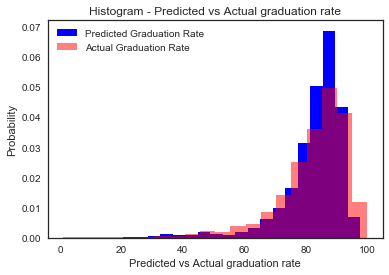

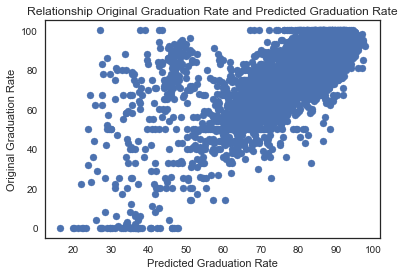

66.33386872142749


In [338]:
from sklearn.linear_model import LinearRegression
columns = ['MASP','MASR','MBLP','MBLR','MHIP','MHIR','MWHP','MWHR','CWDP','CWDR',
           'ECDP','ECDR','LEPP','LEPR','FRLR']

X = acgr2014[columns]
y = acgr2014[['ALLP']]

# This creates a LinearRegression object
lm = LinearRegression()
lm
lm.fit(X, acgr2014.ALLP)

print('Estimated intercept coefficient:', lm.intercept_)
print('Number of coefficients:', len(lm.coef_))

# The coefficients
print(pd.DataFrame(list(zip(X.columns, lm.coef_)), columns = 
                  ['features', 'estimatedCoefficients']))
print(lm.predict(X)[0:5])

X_new = lm.predict(X)
X_old = acgr2014r['ALLP']
#plt.hist(X_new)
#plt.title("Predicted Graduation Rate")
#plt.xlabel("Predicted Graduation Rate")
#plt.ylabel("Frequency")
#plt.show()

plt.hist(X_new, bins=20, histtype='bar', normed=True, color='b', label='Predicted Graduation Rate')
plt.hist(X_old, bins=20, histtype='bar', normed=True, color='r', alpha=0.5, label='Actual Graduation Rate')
plt.title("Histogram - Predicted vs Actual graduation rate")
plt.xlabel("Predicted vs Actual graduation rate")
plt.ylabel("Probability")
plt.legend()
plt.show()

plt.scatter(X_new, acgr2014.ALLP)
plt.xlabel("Predicted Graduation Rate")
plt.ylabel("Original Graduation Rate")
plt.title("Relationship Original Graduation Rate and Predicted Graduation Rate")

plt.show()

print(np.mean((acgr2014.ALLP - X_new) ** 2))

(9704, 15) (9704, 1)
(1079, 15) (1079, 1)


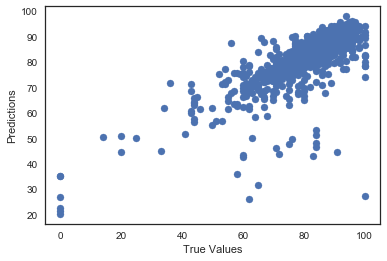

Score: 0.614289446235


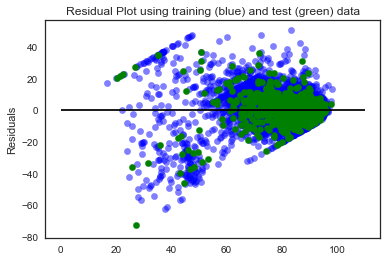

In [364]:
columns = ['MASP','MASR','MBLP','MBLR','MHIP','MHIR','MWHP','MWHR','CWDP','CWDR',
           'ECDP','ECDR','LEPP','LEPR','FRLR']

df = acgr2014[columns]
y = acgr2014[['ALLP']]

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

print("Score:", model.score(X_test, y_test))

plt.scatter(lm.predict(X_train), lm.predict(X_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(X_test), lm.predict(X_test) - y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 110)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

plt.show()

### Machine Learning using Logistics Regression

In [340]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# add "Rank" column: 1 - graduation rate > 83%, 0 - graduation rate < 83%
acgr2014['RANK'] =  acgr2014['ALLP'].map(lambda x: 'Low' if x < 83 else 'High')

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(acgr2014[[
    'MASP','MASR','MBLP','MBLR','MHIP','MHIR','MWHP','MWHR','CWDP','CWDR',
    'ECDP','ECDR','LEPP','LEPR','FRLR']].values, 
    (acgr2014.RANK == "High").values,random_state=5)

lm = LogisticRegression()

# Fit the model on the trainng data.
lm.fit(Xlr, ylr)

# Print the accuracy from the testing data.
print(accuracy_score(lm.predict(Xtestlr), ytestlr))

0.848664688427


In [363]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x):
        clf.fit(x[train], y[train])
        result += score_func(clf.predict(x[test]), y[test])
    return result / nfold

lr = LogisticRegression()
score = cv_score(lr, Xlr, ylr)

print(score)

#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

max_score = 0

for C in Cs:
        clf = LogisticRegression(C=C)
        score = cv_score(clf, Xlr, ylr)

        if score > max_score:
            max_score = score
            best_C =C
print(max_score, best_C)

clfl=LogisticRegression(C=best_C)
clfl.fit(Xlr, ylr)
ypred = clfl.predict(Xtestlr)

print(accuracy_score(ypred, ytestlr))

0.851366086383
0.861629946956 100
0.861275964392


### Machine Learning using Random Forest Classifier

In [358]:
from sklearn.ensemble import RandomForestClassifier

# Add a new column with the column name with maximum %, this is what we are going to try to predict
acgr2014['MARA'] = acgr2014[['MASR','MBLR','MHIR','MWHR','CWDR']].idxmax(axis=1)

acgr2014['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# Create two new dataframes, one with the training rows, one with the test rows
train, test = acgr2014[acgr2014['is_train']==True], acgr2014[acgr2014['is_train']==False]

# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

# Create a list of the feature column's names
features = ['MASP','MASR','MBLP','MBLR','MHIP','MHIR','MWHP','MWHR','CWDP','CWDR',
           'ECDP','ECDR','LEPP','LEPR','FRLR']

y = pd.factorize(train['MARA'])[0]

# View target
print(y)

# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=2, random_state=0)

# Train the Classifier to take the training features and learn how they relate
clf.fit(train[features], y)

print(clf.predict(test[features]))

# View the predicted probabilities of the first 10 observations
print(clf.predict_proba(test[features])[0:10])

Number of observations in the training data: 8177
Number of observations in the test data: 2606
[0 0 0 ..., 0 0 0]
[0 0 0 ..., 0 0 0]
[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]


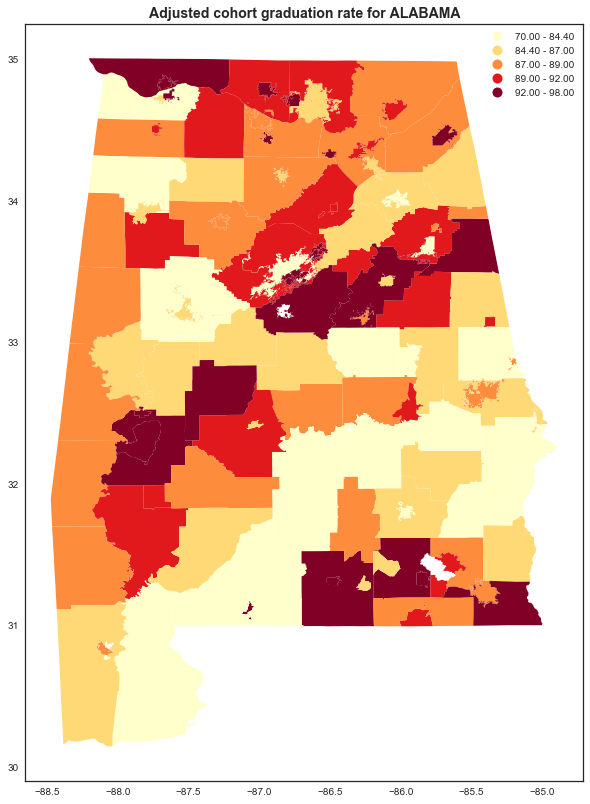

In [356]:
acgrAL2014 = acgr2014[acgr2014['STATE'] == 'ALABAMA']

sf = gpd.GeoDataFrame.from_file("data/tl_2014_01_unsd/tl_2014_01_unsd.shp")
sf.rename(index=str, columns={"GEOID": "LEAID"}, inplace=True)

response_map = pd.merge(sf, acgrAL2014, on='LEAID')
ax = response_map.plot(column='ALLP', scheme='quantiles', k=5, cmap='YlOrRd', legend=True, figsize=(10,20));
ax.set_title('Adjusted cohort graduation rate for ALABAMA', fontsize = 14, fontweight = 'bold');